In [1]:
import pandas as pd
import re
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.utils import resample
warnings.filterwarnings('ignore')
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /Users/lila/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cel biznesowy

Celem naszego projektu jest wprowadzenie automatycznej moderacji komentarzy w celu wykrywania krytyki i problemów, umożliwiając twórcy szybkiej reakcji na negatywne opinie, poprawę jakości interakcji pod filmem oraz redukcja hejtu, czy spamu.

Model, który w tym celu tworzymy na podstawie treści komentarzy będzie skutecznie klasyfikował je na komentarze negatywne oraz pozytywne i neutralne. 

Będzie to model charakteryzujący się:
- dobrą precyzją (tak aby za dużo pozytywnych komentarzy nie było usuwanych i filmy lub twórca nie traciły na popularności)
- wysoką czułością (zależy nam na wykryciu możliwie wszystkich negatywnych komentarzy).

Koszty błędów modelu:
- FN(False Negative) – źle wykryty negatywny komentarz (złe samopoczucie użytkowników, złe skojarzenia z marką lub twórcą, firma może zostać oskarżona o niedbałość jeśli nie odpowiada na negatywne komentarze).
- FP(False Positive) – źle wykryty pozytywny lub neutralny komentarz (utrata pozytywnych opinii, mniejsza popularność filmu).

Nacisk chcemy położyć przede wszystkim na prawidłowe wykrywanie negatywnych komentarzy, ponieważ konsekwencje z ich niepoprawnym wykryciem są nieporównywalnie gorsze od złego wykrywania pozytywnych. Zatem naszym priorytetem jest zminimalizowanie wielkości FN. 

# Data clenianig -- getting rid of null values and duplicates

In [2]:
df = pd.read_csv("YoutubeCommentsDataSet.csv")

df.info()
df.describe()

print("\nNULL count:")
print(df.isnull().sum())
print()

print("Unique rows:", df["Comment"].nunique())
print("Duplicate rows:", df.duplicated().sum())

duplicated_comments = df[df.duplicated()]
duplicated_comments.head(25)

print("Unique values in duplicated comments: ", duplicated_comments["Comment"].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB

NULL count:
Comment      44
Sentiment     0
dtype: int64

Unique rows: 17871
Duplicate rows: 531
Unique values in duplicated comments:  346


In [3]:
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


Poniewaz brakujących wartości jest bardzo mało i nie mają one wartości Sentiment, uznałyśmy, ze nie ma przeszkód by je usunąć

W celu uniknięcia overfitting usunęłyśmy take wartości zduplikowane (nie dają one więcej informacji modelowi)

In [4]:
#Discard empty entries (44/18408) and duplicates (?)
df = df.dropna()
df = df.drop_duplicates()

# Adding features
- Sentiment_Score_nltk (ciągły wskaźnik sentymentu komentarza o warotściach [-1, 1])
- Comment_length (długość komentarza)
- Starts_with_i - czy komentarz zaczyna się od I 
- Personal_Pronoun_count - liczba zaimków osobowych, takich jak he, she, i, etc.
- Number_of_phrases (czyli podział komentarza według spójników "but", "and", "because")
- Avg_phrase_length (średnia długość frazy)
- Number_of_words (liczba słów)
- Avg_word_length (średnia długość słów)
- Unique_word_ratio (stosunek liczby unikalnych słów do wszystkich słów, im większa tym bardziej rozbudowane słownictwo)

In [5]:
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lila/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
#Dodajemy feature: Sentiment Score ntlk -- ciągły sentyment, wart. od -1 do 1.

sia = SentimentIntensityAnalyzer()
df['Sentiment_Score_nltk'] = df['Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [7]:
#Dodajemy feature Starts_with_I
df['Starts_with_i'] = df['Comment'].str.startswith("i")
#Dodajemy feature Comment_Length
df['Comment_Length'] = df['Comment'].str.len()
#Mapowanie sentymentu 
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df['Sentiment_num'] = df['Sentiment'].map(sentiment_mapping)

In [8]:
#Tworzenie zmiennej Personal_Pronoun_Count
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}
def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)
    
df["Personal_Pronoun_count"] = df["Comment"].apply(lambda x: count_personal_pronouns(x))

In [9]:
#Tworzenie zmiennych Number_of_phrases, Number_of_words, Avg_phrase_length, Avg_word_length, Unique_word_ratio
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }

df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
df_complexity = pd.DataFrame(df_complexity.tolist())
df = df.reset_index(drop=True)
df_complexity = df_complexity.reset_index(drop=True)
df = pd.concat([df, df_complexity], axis = 1)

In [10]:
df.head()

,Comment,Sentiment,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
0,lets not forget that apple pay in 2014 require...,neutral,0.6774,False,317,0,3,4,57,14.250000,4.578947,0.789474
1,here in nz 50 of retailers don’t even have con...,negative,0.8360,False,163,-1,1,3,33,11.000000,4.090909,0.878788
2,i will forever acknowledge this channel with t...,positive,0.8718,True,183,1,5,3,31,10.333333,4.935484,0.903226
3,whenever i go to a place that doesn’t take app...,negative,-0.8914,False,450,-1,13,7,99,14.142857,3.717172,0.616162
4,apple pay is so convenient secure and easy to ...,positive,0.6786,False,135,1,2,4,26,6.500000,4.230769,0.961538


# Data exploration

## Feature distributions

In [11]:
df.describe()

,Sentiment_Score_nltk,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
count,17874.000000,17874.000000,17874.000000,17874.000000,17874.000000,17874.000000,17874.000000,17874.000000,17874.000000
mean,0.391501,177.705214,0.488811,3.073011,2.824382,33.543135,13.055658,4.468194,0.896979
std,0.476521,252.135479,0.713556,4.649475,3.151819,46.168373,17.285560,2.869250,0.105330
min,-0.997300,2.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.193878
25%,0.000000,66.000000,0.000000,1.000000,1.000000,13.000000,7.500000,3.928571,0.833333
50%,0.510600,113.000000,1.000000,2.000000,2.000000,22.000000,10.666667,4.285714,0.916667
75%,0.806150,201.000000,1.000000,4.000000,3.000000,39.000000,15.000000,4.696970,1.000000
max,0.999800,7847.000000,1.000000,120.000000,84.000000,1447.000000,1447.000000,209.000000,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17874 entries, 0 to 17873
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Comment                 17874 non-null  object 
 1   Sentiment               17874 non-null  object 
 2   Sentiment_Score_nltk    17874 non-null  float64
 3   Starts_with_i           17874 non-null  bool   
 4   Comment_Length          17874 non-null  int64  
 5   Sentiment_num           17874 non-null  int64  
 6   Personal_Pronoun_count  17874 non-null  int64  
 7   Number_of_phrases       17874 non-null  int64  
 8   Number_of_words         17874 non-null  int64  
 9   Avg_phrase_length       17874 non-null  float64
 10  Avg_word_length         17874 non-null  float64
 11  Unique_word_ratio       17874 non-null  float64
dtypes: bool(1), float64(4), int64(5), object(2)
memory usage: 1.5+ MB


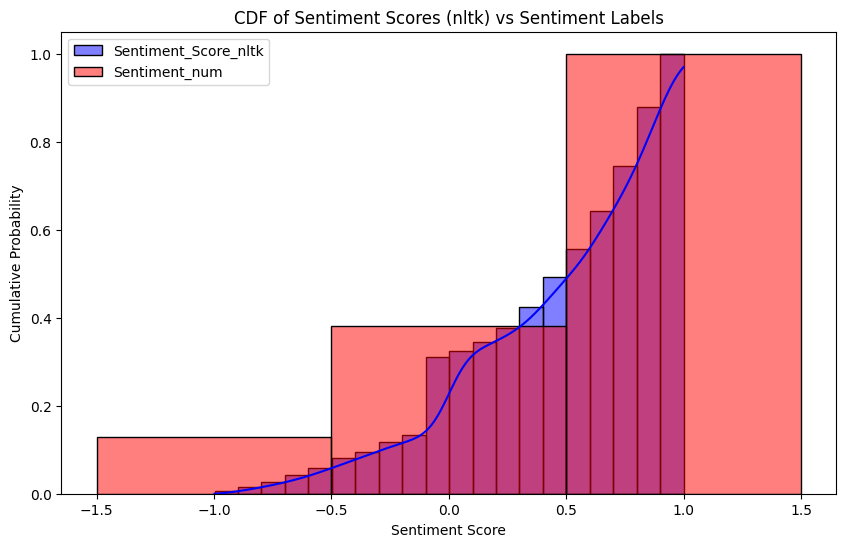

In [13]:
plt.figure(figsize=(10, 6))

# CDF for Sentiment_Score_nltk (continuous)
sns.histplot(df['Sentiment_Score_nltk'], bins=20, stat='density', cumulative=True, kde=True, color='blue', label='Sentiment_Score_nltk', alpha=0.5)

# CDF for Sentiment_num (discrete)
sns.histplot(df['Sentiment_num'], discrete=True, stat='density', cumulative=True, color='red', label='Sentiment_num', alpha=0.5)

# Labels and legend
plt.xlabel("Sentiment Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Sentiment Scores (nltk) vs Sentiment Labels")
plt.legend()
plt.show()

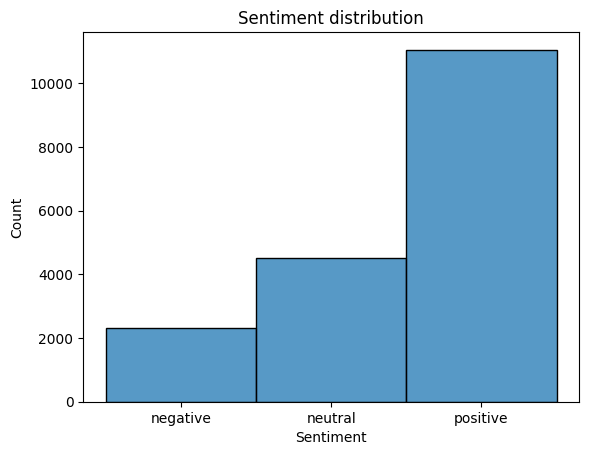

In [14]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
sentiments = sns.histplot(df['Sentiment'])
sentiments.set_title("Sentiment distribution")
plt.show()

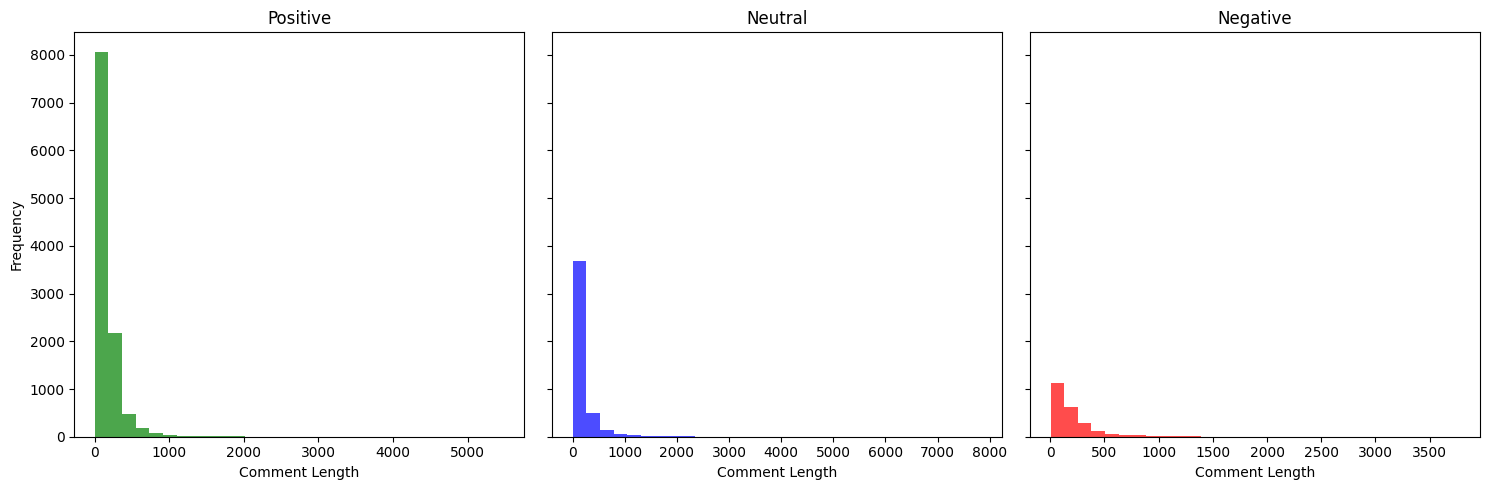

In [15]:
positive = df[df['Sentiment'] == 'positive']
negative = df[df['Sentiment'] == 'negative']
neutral = df[df['Sentiment'] == 'neutral']
# Tworzenie figure i subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Histogram dla pozytywnych komentarzy
axes[0].hist(positive['Comment_Length'], bins=30, color='green', alpha=0.7)
axes[0].set_title('Positive')
axes[0].set_xlabel('Comment Length')
axes[0].set_ylabel('Frequency')

# Histogram dla negatywnych komentarzy
axes[2].hist(negative['Comment_Length'], bins=30, color='red', alpha=0.7)
axes[2].set_title('Negative')
axes[2].set_xlabel('Comment Length')

# Histogram dla neutralnych komentarzy
axes[1].hist(neutral['Comment_Length'], bins=30, color='blue', alpha=0.7)
axes[1].set_title('Neutral')
axes[1].set_xlabel('Comment Length')

# Optymalizacja wyglądu
plt.tight_layout()
plt.show()

In [16]:
df.groupby('Sentiment')['Comment_Length'].agg(['mean', 'median', 'std'])

,mean,median,std
Sentiment,,,
negative,210.874407,134.0,265.276426
neutral,195.100378,98.0,351.601598
positive,163.666546,114.0,192.739614


Widać, że komentarze negatywne mają najwyższą średnią. Komentarze neutralne są najbardziej zróżnicowane pod kątem długości, a komentarze pozytywne najmniej. Pozytywne komentarze w większości są krótkie i zwięzłe co może sugerować, że ludzie mniej się rozpisują, gdy wyrażają swoją aprobatę, natomiast dłużej, gdy coś im się nie podoba. Komentarze neutralne objemują zarówno krótkie, jak i rozbudowane analizy. Można zauważyć, że najdłuższe komentarze napisane przez użytkowników są neutralne.


<Axes: xlabel='Comment_Length', ylabel='Count'>

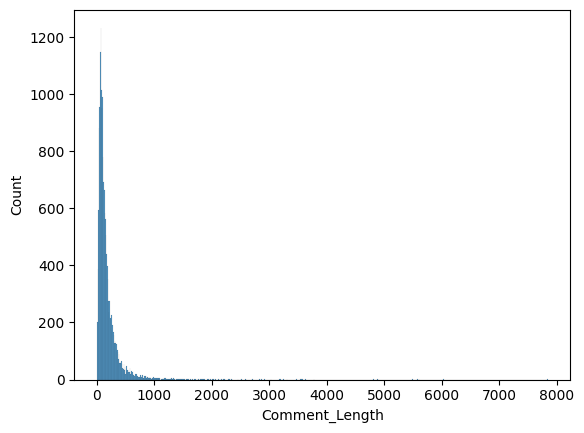

In [17]:
sns.histplot(df['Comment_Length'])

In [18]:
df['Comment_Length'].describe()

count    17874.000000
mean       177.705214
std        252.135479
min          2.000000
25%         66.000000
50%        113.000000
75%        201.000000
max       7847.000000
Name: Comment_Length, dtype: float64

In [19]:
df.sort_values(by="Comment_Length", ascending = True)

bins = [0, df['Comment_Length'].quantile(0.25), df['Comment_Length'].quantile(0.5), df['Comment_Length'].quantile(0.75), df['Comment_Length'].max()]
labels = ['short', 'medium', 'long', 'very long']
df['Comment_Length_Binned'] = pd.cut(df['Comment_Length'],bins = bins, labels = labels, right = False)

print([0, df['Comment_Length'].quantile(0.25), df['Comment_Length'].quantile(0.5), df['Comment_Length'].quantile(0.75), df['Comment_Length'].max()])

[0, np.float64(66.0), np.float64(113.0), np.float64(201.0), np.int64(7847)]


<Axes: xlabel='Sentiment', ylabel='Count'>

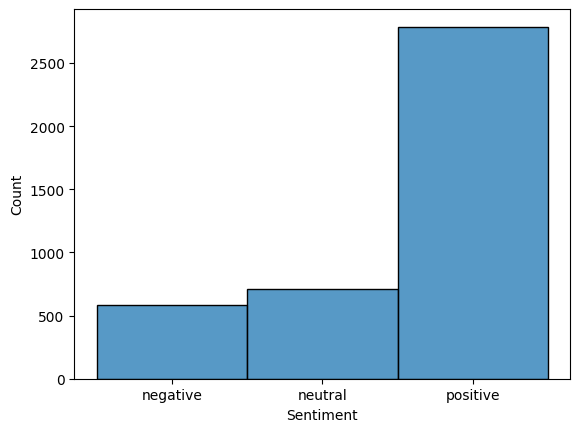

In [20]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
sns.histplot(df[df["Starts_with_i"] == True]['Sentiment'])

Można zauważyć, że komentarze zaczynające się od "i" to w zdecydowanej większości komentarze pozytywne, co może być przydatne w rozpoznawaniu ich przez model.

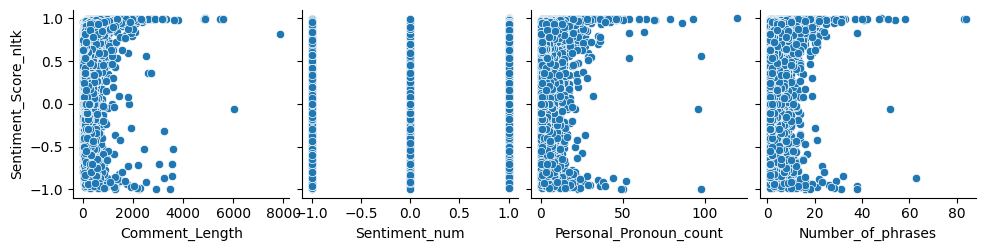

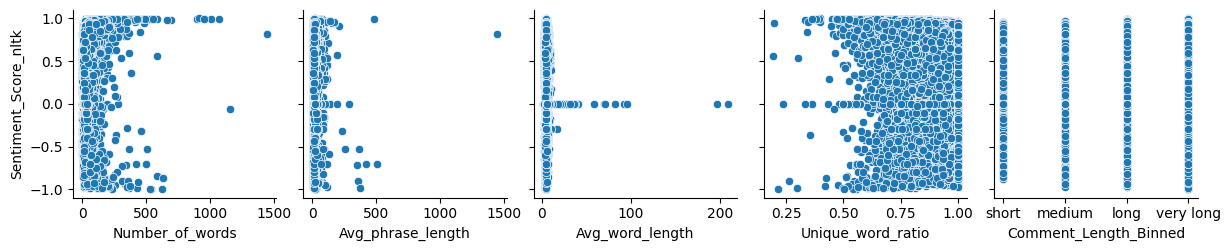

In [21]:
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[4:8])
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[8:])

plt.show()

Widać, że w przypadkach wyższych wartości Sentiment_score_nltk, tym komentarz ma większe ilości zaimków osobowych (Personal_pronoun_count), jak i większą ilością fraz - większa rozbudowalność komentarza. 

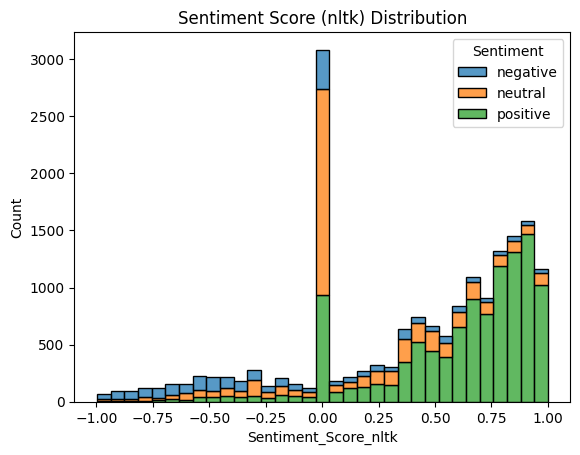

In [22]:
sentiments = sns.histplot(df, x='Sentiment_Score_nltk', hue='Sentiment', multiple='stack')
sentiments.set_title("Sentiment Score (nltk) Distribution")
plt.show()

## Distributions for Sentiment_Score_nltk = 0

In [23]:
zero_score = df[df["Sentiment_Score_nltk"] == 0]
sentiment_order = ["negative", "neutral", "positive"]

zero_score['Sentiment'] = pd.Categorical(zero_score['Sentiment'], categories=sentiment_order, ordered=True)

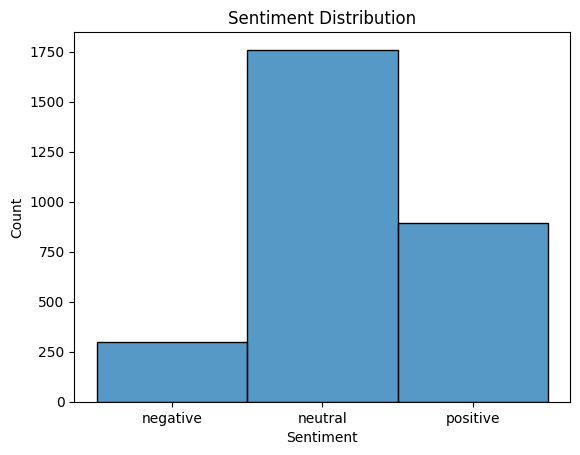

In [24]:
sentiments = sns.histplot(zero_score['Sentiment'], discrete=True)

sentiments.set_title("Sentiment Distribution")
plt.show()

Wiele z komentarzy o Sentiment_Score_nltk = 0 jest pozytywnych, czy negatywnych. Przy tak duzej liczności tej klasy moze to sprawić trudności w jej klasyfikacj 

<Axes: xlabel='Comment_Length_Binned', ylabel='Count'>

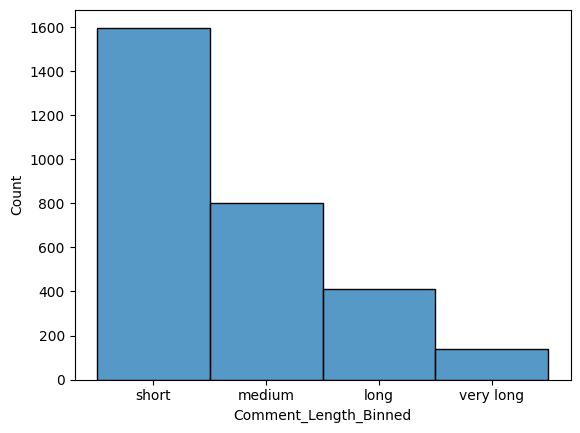

In [25]:
bins = [0, df['Comment_Length'].quantile(0.25), df['Comment_Length'].quantile(0.5), df['Comment_Length'].quantile(0.75), df['Comment_Length'].max()]
labels = ['short', 'medium', 'long', 'very long']
df['Comment_Length_Binned'] = pd.cut(zero_score['Comment_Length'],bins = bins, labels = labels, right = False)
sns.histplot(zero_score['Comment_Length_Binned'])


Widać, że większość komentarzy o zerowym Sentiment_score_nltk to komentarze krótkie.

<Axes: xlabel='Comment_Length', ylabel='Count'>

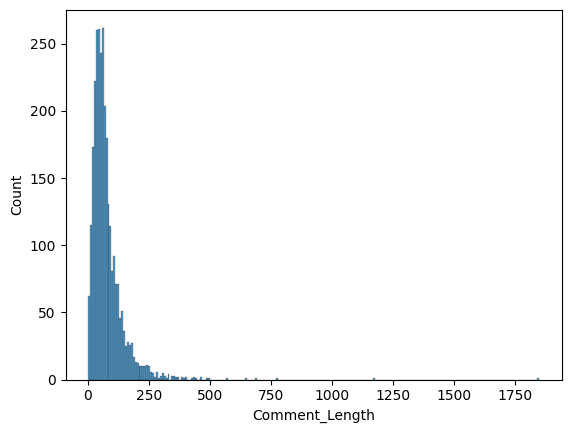

In [26]:
sns.histplot(zero_score, x='Comment_Length')

## Feature correlation matrix

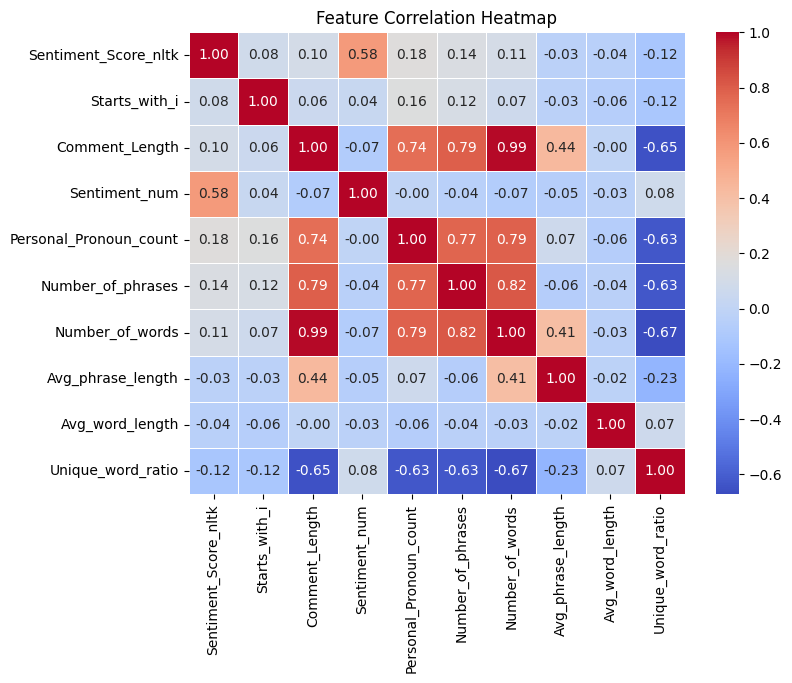

In [27]:
corr_matrix = df.drop(columns=["Comment", "Sentiment", "Comment_Length_Binned"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Splitting into train, test, and validation sets

In [28]:
from sklearn.model_selection import train_test_split

# First, split the dataset into train (80%) and temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.51, stratify=df['Sentiment'], random_state=42)

# Then, split temp into validation (10%) and test (10%) - equal proportion
val_df, test_df = train_test_split(temp_df, test_size=0.59, stratify=temp_df['Sentiment'], random_state=42)

# Print sizes
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8758, Validation size: 3737, Test size: 5379


# Balancing the training set

In [29]:
import pandas as pd
from sklearn.utils import resample

# Check class distribution
print(train_df["Sentiment"].value_counts())

# Separate majority and minority classes
train_positive = train_df[train_df["Sentiment"] == "positive"]
train_negative = train_df[train_df["Sentiment"] == "negative"]
train_neutral = train_df[train_df["Sentiment"] == "neutral"]

# Set the desired sample size (same as the majority class)
desired_size = len(train_positive)

# Oversample the minority classes
df_negative_oversampled = resample(train_negative, 
                                   replace=True,  # Sample with replacement
                                   n_samples=desired_size,  # Match majority class size
                                   random_state=42)

df_neutral_oversampled = resample(train_neutral, 
                                  replace=True, 
                                  n_samples=desired_size, 
                                  random_state=42)

# Combine all data back together
df_balanced = pd.concat([train_positive, df_negative_oversampled, df_neutral_oversampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(df_balanced["Sentiment"].value_counts())

Sentiment
positive    5416
neutral     2207
negative    1135
Name: count, dtype: int64
Sentiment
negative    5416
neutral     5416
positive    5416
Name: count, dtype: int64
